**Introduction**  
We are going to look at the Pima Indians Database to predict the onset of diabetes. This is a supervised learning project, the dataset used has known outcomes. We will be looking at 4 different models and hyperparameter optimizing one of them. The goal is to develop and find the best model based on accuracy, precision and recall. This is extremely important in the healthcare field because it can help inform the populations on prevention strategies and help high risk groups.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

**Exploratory Data Analysis (EDA)**  
Data is in tabular form and has 768 rows and 9 columns (including the outcome). Citation at the bottom of notebook.  
Data Distributions:  
| Feature | Distribution | Insight |
|:--------------|:-------------------:|:-------------------:|
| Pregnancies | right-skewed | There's clustering at the lower end which is expected |
| Glucose | approximately normal | Some zero values that likely indicate missing data |
| BloodPressure | approximately normal | Zero values present which are likely errors |
| SkinThickness | right-skewed | Many zero values, indicating missing or incorrect data |
| Insulin | right-skewed with many outliers | Large number of zero values, also significant outliers |
| BMI | approximately normal | Zero values present which are likely errors |
| DiabetesPedigreeFunction | right-skewed | Distribution is spread out with a long tail on the right |
| Age | right-skewed | Majority of subjects are in the younger age range |

Correlation Matrix:  
We see that the Glucose is a very significant predictor for the outcome, it has the highest positive correlation. Other positive predictors are BMI, Pregnancies, Age and Insulin.

Data Transformation and Cleaning:  
After our initial inspection we can see that theres quite a range and distribution on many of our variables, to fix this we will normalize the data. Another problem is missing data, for instance having a blood pressure of zero would most likely mean the person is no longer with us or having an immediate issue. To fix this were going to remove all the zeros where they are non-sensical and replace them with NaN, so we can then replace them with the median value.

In [2]:
data_path = 'Data/diabetes.csv'
df = pd.read_csv(data_path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
#Identify missing values
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)

#Data Cleaning replace missing values with median
for column in columns_with_zeros:
    df[column].fillna(df[column].median(), inplace=True)

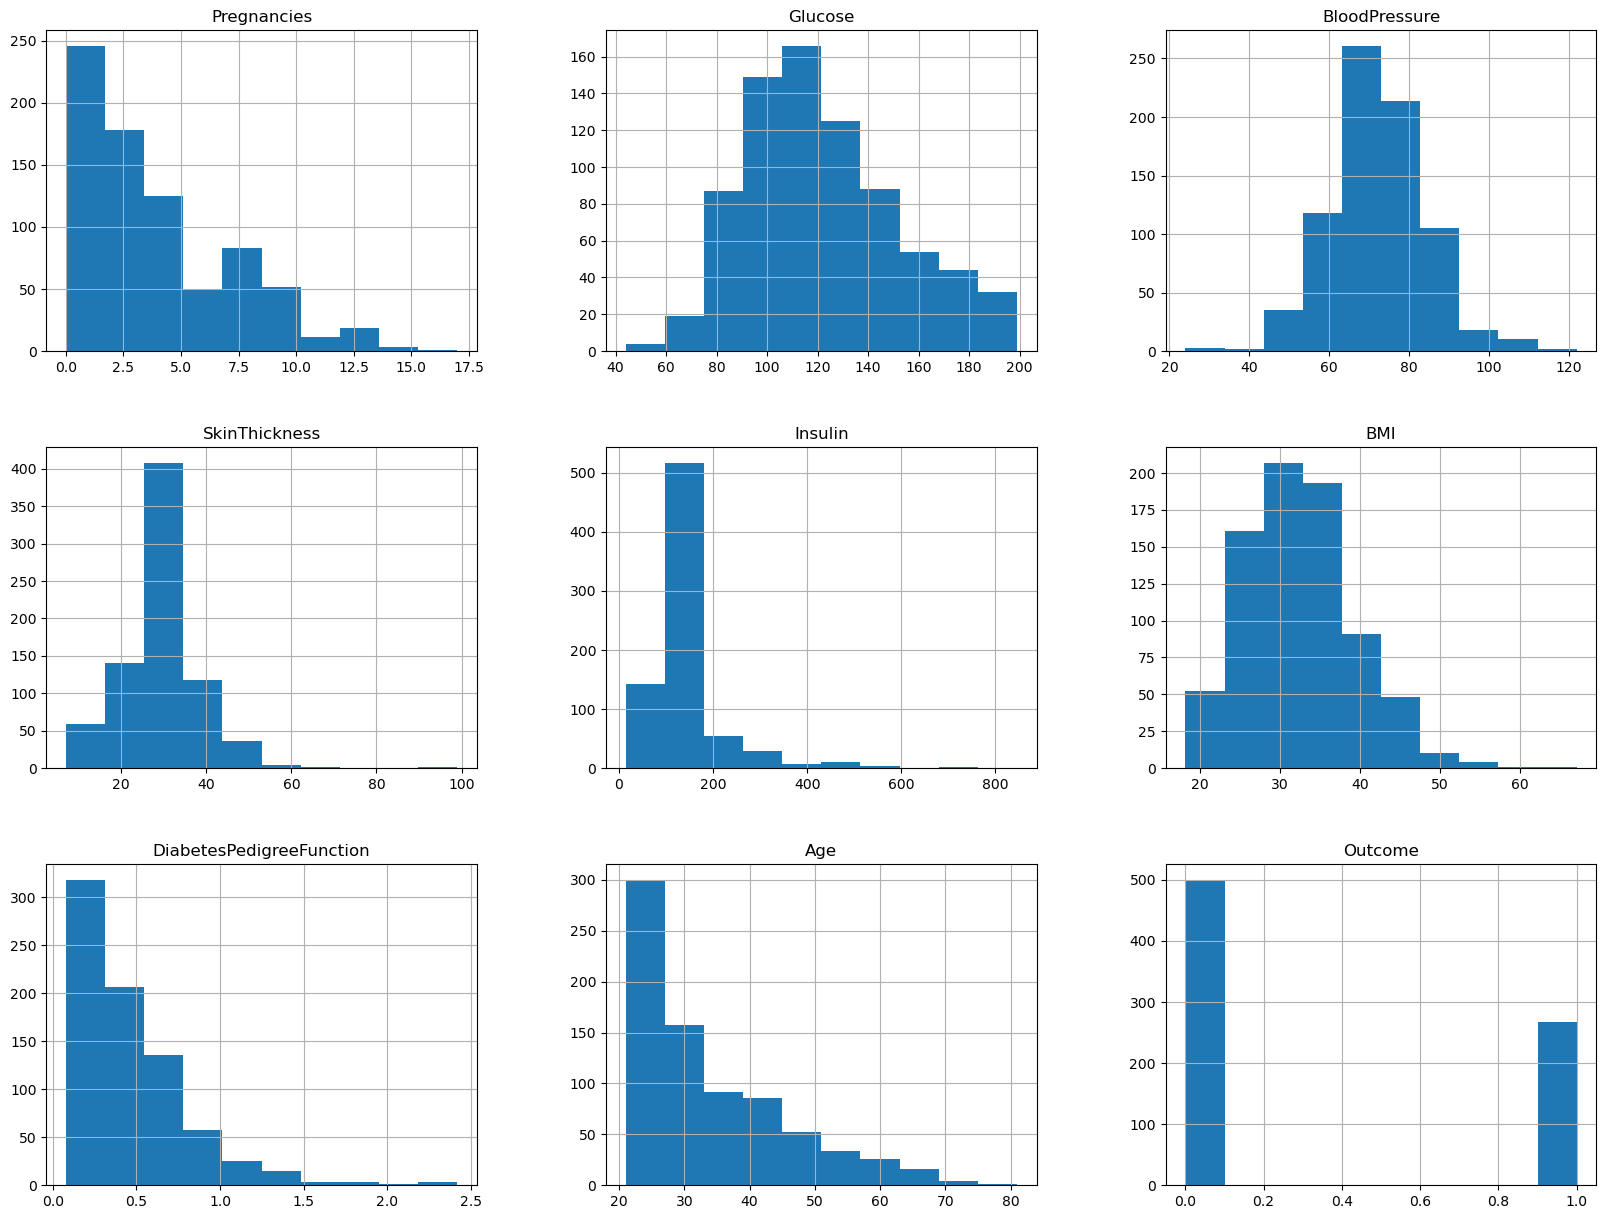

In [4]:
#Histograms for each feature
df.hist(figsize=(20, 15))
plt.show()

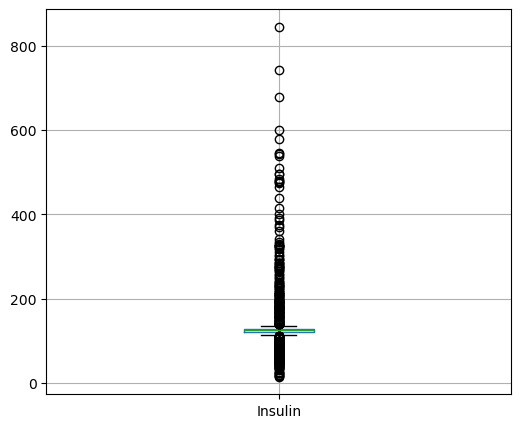

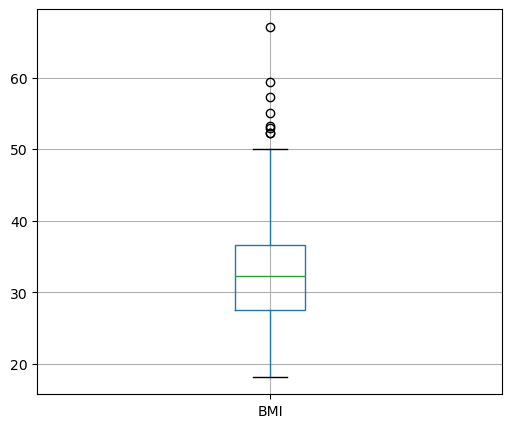

In [5]:
#Box plots for insulin and BMI
df.boxplot(column=['Insulin'], figsize=(6, 5))
plt.show()

df.boxplot(column=['BMI'], figsize=(6, 5))
plt.show()

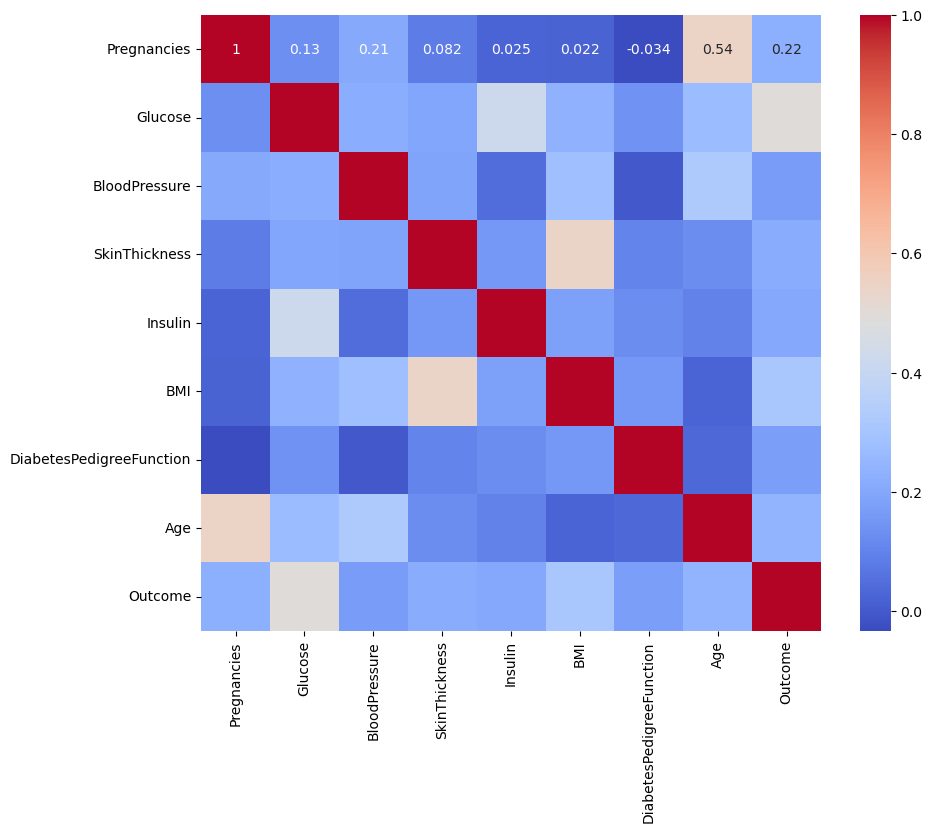

In [6]:
#Correlation Analysis
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

**Analysis of Multiple Models and Hyperparameter Tuning**  
Here's a brief description of the 5 code cells and steps I'm taking below:  
1. Preparing the Data models, removing the label 'Outcome' and scaling the data and creating a training and test set
2. Initializing all the models we want to evaluate
3. Defining a function to train and evaluate those models, then running them through
4. Hyparparameter Tuning the Random Forest model
5. Printing results

In [7]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
logreg = LogisticRegression(random_state=1)
svc = SVC(random_state=1, probability=True)
rf = RandomForestClassifier(random_state=1)
gbm = GradientBoostingClassifier(random_state=1)

models = {'Logistic Regression': logreg, 'SVC': svc, 'Random Forest': rf, 'Gradient Boosting': gbm}

In [9]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    performance = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
    return performance

model_performance = {}
for name, model in models.items():
    performance = train_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    model_performance[name] = performance

In [10]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [11]:
performance_df = pd.DataFrame(model_performance).transpose()

print(performance_df)
print("Best Hyperparameters for Random Forest:", best_params)
print("Best Score from Grid Search:", best_score)

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.772727   0.738095  0.563636  0.639175  0.866667
SVC                  0.785714   0.789474  0.545455  0.645161  0.884940
Random Forest        0.785714   0.711538  0.672727  0.691589  0.852617
Gradient Boosting    0.785714   0.739130  0.618182  0.673267  0.860973
Best Hyperparameters for Random Forest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
Best Score from Grid Search: 0.8365524554639541


**Analysis of results and Conclusions**  
As you can see from the results all of the accuracies were very close. But there are some noticeable differences, the SVC model has the highest precision meaning it can predict the positives without creating many false positives. While the Random Forest model has the highest recall meaning it is effective at identifying all positives instances. These results also show how important hyperparameter optimization can be, the performance of the optimized Random Forest model was significantly better than any of the unoptimized ones.  
To conclude, depending upon your goal you have different model options. For this dataset if your goal is to not have many false positives the SVC model works well, or more realistically if you want to make sure anyone with diabetes gets diagnosed, treatment, etc.. you may want to use the Random Forest model. But then you may need people to go in for further testing to weed out more false positives.

**Resources**  
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In *Proceedings of the Symposium on Computer Applications and Medical Care* (pp. 261–265). IEEE Computer Society Press. Retrieved from [https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data)
